# Introduction

# 0. Prep

In [1]:
% matplotlib inline
from metro import io
from metro import utility
from metro import analysis
from metro import assignment
from metro import viz

import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import numpy as np
import pandas as pd
import cProfile
from IPython.display import display, HTML
import itertools
import math

sns.set_style("white")

In [2]:
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/

Certain analyses in this worksheet are very processor intensive. You have the option of only running them on a subset of the nodes in the graph. To do this, set a value for `n_nodes` below. To run full computations, choose `n_nodes = None`.

In [3]:
n_nodes = 500

# 1. Single-Layer Impact of OD Demand

As a warmup, we'd like to study the behavior of shortest path distributions on the single street layer. To speed up computations, we'll primarily work in igraph throughout this section. 


## 1.1 Universality of shortest paths under uniform demand

Let's start with a uniform demand assumption, in which there is one unit of travel demand from every origin to every destination. We'll vary only the edge-weights. Since we don't need any OD data, we just need the street layer of the multiplex. 

In [4]:
g = utility.nx_2_igraph(multi.layers_as_subgraph(['streets'])) # get the street layer and convert it to igraph
weights = ['congested_time_m', 'free_flow_time_m', 'uniform_time_m'] # define weights we'll use
nodes = np.array([v.index for v in g.vs if g.vs[v.index]['layer'] == 'streets'])
if n_nodes:
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

Now we'll compute shortest paths under each of the edge weights and collect them into a dataframe for easy visualization. 

In [5]:
d = {weight : analysis.path_lengths_igraph(g, nodes, weight, mode = 'array') for weight in weights}
uniform_demand = pd.DataFrame(d)

uniform_demand = uniform_demand[weights]

for weight in weights:
    uniform_demand = uniform_demand[uniform_demand[weight] != np.inf]

Time to visualize! We'll first plot the distributions on the left, and beside them the standardized distributions on the right. 

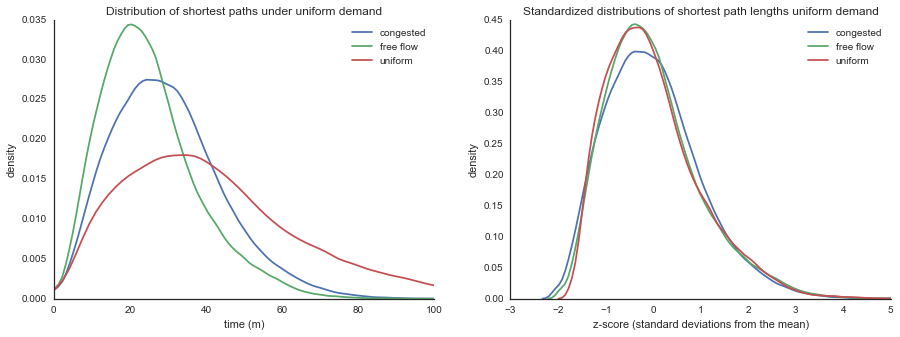

In [6]:
fig = plt.figure(figsize = (15, 5))

ax = fig.add_subplot(121)

sns.distplot(uniform_demand['congested_time_m'], kde = True, hist = False, label = 'congested')
sns.distplot(uniform_demand['free_flow_time_m'], kde = True, hist = False, label = 'free flow')
sns.distplot(uniform_demand['uniform_time_m'], kde = True, hist = False, label = 'uniform')

ax.set(xlim = (0, 100), xlabel = 'time (m)', ylabel = 'density')
sns.despine()

plt.title('Distribution of shortest paths under uniform demand')

ax = fig.add_subplot(122)

sns.distplot(analysis.standardize(uniform_demand['congested_time_m']), kde = True, hist = False, label = 'congested')
sns.distplot(analysis.standardize(uniform_demand['free_flow_time_m']), kde = True, hist = False, label = 'free flow')
sns.distplot(analysis.standardize(uniform_demand['uniform_time_m']), kde = True, hist = False, label = 'uniform')

ax.set(xlim = (-3, 5), xlabel = 'z-score (standard deviations from the mean)', ylabel = 'density')
sns.despine()

plt.title('Standardized distributions of shortest path lengths uniform demand')

These results on the right are relatively intuitive. **Uniform time** leads to the slowest paths, because travellers cannot use highways or other high-speed-limit roads to speed up their journeys. In contrast, **free flow time** weighting encourages travellers to use high-speed-limit throughways as much as convenient. Finally, **congested time** weighting is something of a compromise -- like free flow, there is benefit to using high-speed-limit roads, but the benefits are decreased due to the popularity -- and therefore congestion -- of those roads. 

On the left, something interesting happens -- after standardizing the distributions, we find that they have substantially the same shape! This result is broadly in line with Strano et al., who found that shortest path distributions under uniform demand were much the same (a) between two different cities and (b) under very different edge-weighting schemata. The common distribution looks to be either lognormal, Rayleigh, or $\Gamma$ -- not sure at this stage how to choose among these. 

Suggestively, however, the congested distribution is somewhat different from the free flow and uniform distributions, suggesting that actual network usage data may change the universal picture. 

For reference, quick summary statistics:

In [7]:
np.round(uniform_demand.describe(),1)

,congested_time_m,free_flow_time_m,uniform_time_m
count,250000.0,250000.0,250000.0
mean,29.9,25.2,42.1
std,14.5,12.9,24.3
min,0.0,0.0,0.0
25%,19.3,15.9,24.2
50%,28.6,23.3,38.2
75%,38.7,32.1,55.4
max,120.5,109.1,206.3


## 1.2 Impact of OD demand

Since we're interested in OD demand, we need to add the taz layer to the graph. We'll also need to import a table of OD values. 

In [8]:
g = utility.nx_2_igraph(multi.layers_as_subgraph(['streets', 'taz']))
od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt', pivot = False)

computing od dictionary
OD dict computed in 0.4 m


First, we'll create a 'base' dataframe to hold our results. Each row corresponds to an OD pair, and will include the OD labels, flow between them, and shortest path lengths. The below is some bookeeping to set that up. 

In [9]:
nodes = np.array([v.index for v in g.vs if v['layer'] == 'taz'])

indices = [(x,y) for (x,y) in itertools.product(range(len(nodes)), repeat=2)]
o_i = [x for (x,y) in indices]
d_i = [y for (x,y) in indices]

od_demand = pd.DataFrame({'o_i':o_i, 'd_i':d_i})

od_demand['o'] = od_demand['o_i'].map(lambda o_i : nodes[o_i]) # igraph keys
od_demand['d'] = od_demand['d_i'].map(lambda d_i : nodes[d_i]) # igraph keys

name_lookup = {v.index : g.vs[v.index]['name'] for v in g.vs} # lookup to get nx labels
od_demand['o_nx'] = od_demand['o'].map(name_lookup.get) # nx keys for later
od_demand['d_nx'] = od_demand['d'].map(name_lookup.get) # nx keys for later

od_demand = od_demand.merge(od)

Now we're ready to compute shortest paths and merge them into the data frame. 

In [10]:
for weight in weights:
    p = analysis.path_lengths_igraph(g, nodes, weight, mode = 'list')
    q = [(nodes[i],nodes[j],p[i][j]) for i in range(len(nodes)) for j in range(len(nodes))]
    o = [tup[0] for tup in q]
    d = [tup[1] for tup in q]
    p = [tup[2] for tup in q]
    lengths = pd.DataFrame({'o' : o, 'd' : d, weight : p})
    od_demand = od_demand.merge(lengths)

In [11]:
def OD_weighted_hist(df, measure, label, **kwargs):
    n = 100
    hist = np.histogram(df[measure], weights = df['flow_norm'], normed = True, bins = n)
    x = hist[1][:n] 
    y = hist[0]
    plt.plot(x,y, label = label, **kwargs)

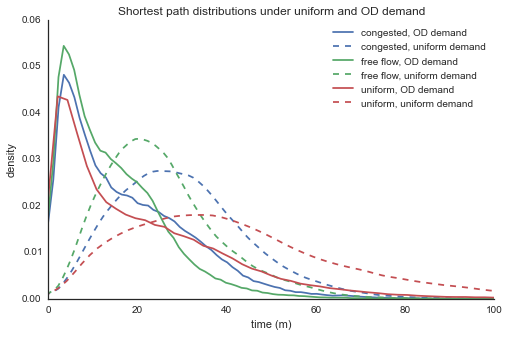

In [12]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)

current_palette = sns.color_palette()

OD_weighted_hist(od_demand, 'congested_time_m', label = 'congested, OD demand', color = current_palette[0])
sns.kdeplot(uniform_demand['congested_time_m'], label = 'congested, uniform demand', ls = '--', color = current_palette[0])
OD_weighted_hist(od_demand, 'free_flow_time_m', label = 'free flow, OD demand', color = current_palette[1])
sns.kdeplot(uniform_demand['free_flow_time_m'], label = 'free flow, uniform demand', ls = '--', color = current_palette[1])
OD_weighted_hist(od_demand, 'uniform_time_m', label = 'uniform, OD demand', color = current_palette[2])
sns.kdeplot(uniform_demand['uniform_time_m'], label = 'uniform, uniform demand', ls = '--', color = current_palette[2])

ax.set(xlim = (0, 100), xlabel = 'time (m)', ylabel = 'density')
sns.despine()
plt.legend()
plt.title('Shortest path distributions under uniform and OD demand')

Interesting! We note that (a) the distributions have shifted far to the left -- likely reflecting a preference to live closer to work -- and (b) that each of the OD-weighted distributions has a qualitatively different shape from the others. For reference, the weighted averages are below. They estimate the average commute time under each of the three edge weightings.  

In [13]:
for weight in weights:
    print weight + ' -- ' + str(np.average(od_demand[weight], weights = od_demand['flow_norm']))

congested_time_m -- 18.2852734593
free_flow_time_m -- 15.0326698738
uniform_time_m -- 22.0781689793


## 1.3 Spatial distribution of demand and trip lengths 

Now we'll take a peak at the spatial distribution of travel times. Our main question is: how does mean travel time under congestion change depending on TAZ? 

In [14]:
def wavg(group):
    d = group['congested_time_m']
    w = group['flow_norm']
    return (d * w).sum() / w.sum()

grouped_o = od_demand[od_demand['flow_norm'] > 0].groupby('o_nx')

o_time = grouped_o.apply(wavg)
o = grouped_o.sum()['flow_norm']

grouped_d = od_demand[od_demand['flow_norm'] > 0].groupby('d_nx')
d_time = grouped_d.apply(wavg)
d = grouped_d.sum()['flow_norm']

df = pd.DataFrame({'o' : o, 'o_time' : o_time, 'd' : d, 'd_time' : d_time})

dicts = df.to_dict()

In [15]:
for name in ['o', 'o_time', 'd', 'd_time']:
    nx.set_node_attributes(multi.G, name, 0)
    nx.set_node_attributes(multi.G, name, dicts[name])

/Users/phil/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:931: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/phil/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/phil/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


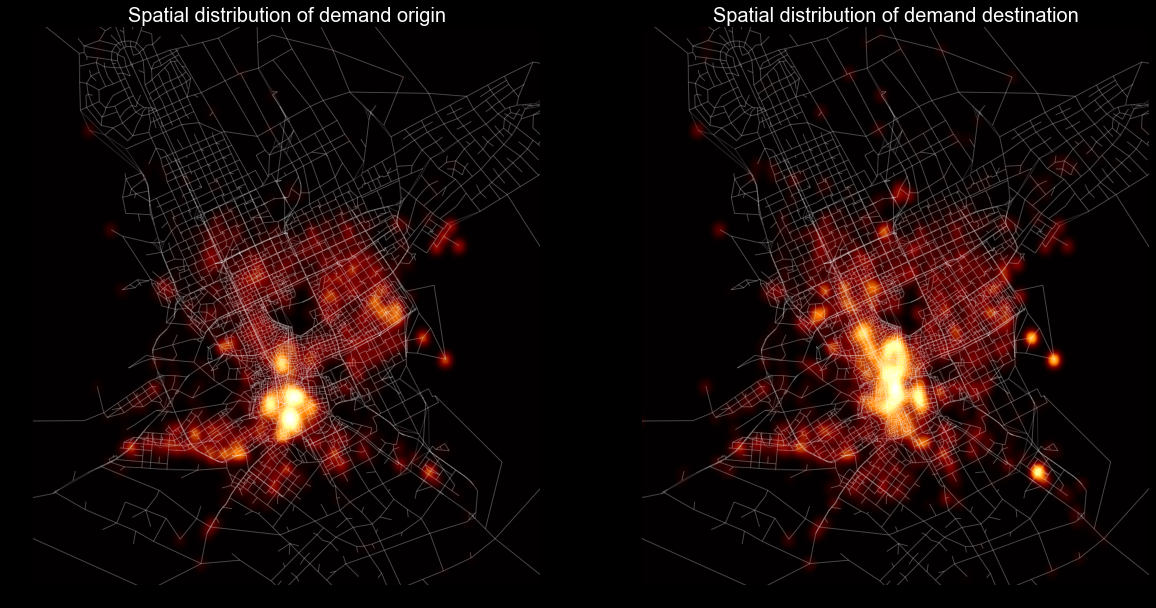

In [16]:
fig = plt.figure(figsize = (2*10,10))
xlim = (46.4167, 47.0167)
ylim = (24.4333, 25.0333)

ax = fig.add_subplot(121)
viz.spatial_plot(multi.G, 
                 attr = 'o', 
                 ax = ax, 
                 layer = 'taz')

ax.set(xlim = xlim, ylim = ylim)
plt.title('Spatial distribution of demand origin', 
              color = 'w', 
              fontsize = 20)

ax = fig.add_subplot(122)
viz.spatial_plot(multi.G, 
                 attr = 'd', 
                 ax = ax, 
                 layer = 'taz')

ax.set(xlim = xlim, ylim = ylim)
plt.title('Spatial distribution of demand destination', 
              color = 'w', 
              fontsize = 20)

fig.set_facecolor("#000000")

Next: 


- Spatial distribution of commute length, no metro. 
- Distribution of OD-weighted shortest path lengths
- Spatial distribution of commute lengths


We can also visualize the spatial distribution of mean trip length. This requires a different kind of visualization since the measure isn't additive. The below is probably not the best we could do, but it gives an idea.  

In [17]:
def bubble_plot(G, size, color, ax, **kwargs):
    G.position = {n : (G.node[n]['lon'], G.node[n]['lat']) for n in G}
    G.size = [G.node[n][size]*.05 for n in G.node]
    G.color = [G.node[n][color] for n in G.node]
    
    n = nx.draw(G, G.position,
        edge_color = 'grey', 
        edge_size = 0.01,
        node_color = G.color,
        node_size = G.size,
        linewidth = 0,
        cmap = 'jet',
        alpha = .5,
        with_labels = False,
        arrows = False,
        **kwargs)

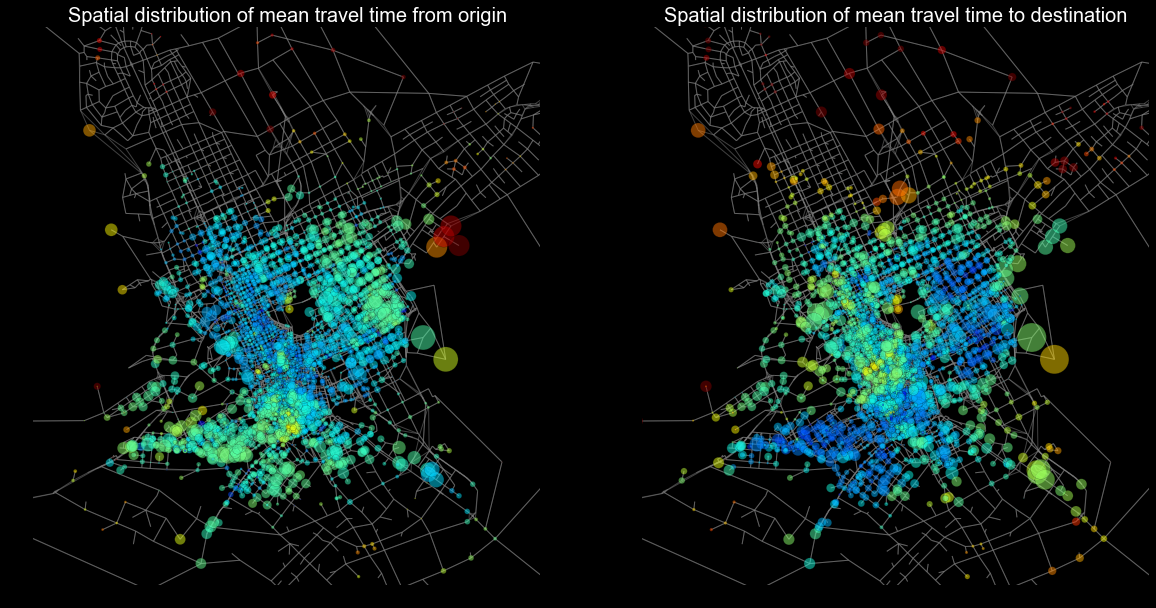

In [18]:
G = multi.G
fig = plt.figure(figsize = (2*10,10))

ax = fig.add_subplot(121)
bubble_plot(G, size = 'o', color = 'o_time', ax = ax, vmax = 45)
plt.title('Spatial distribution of mean travel time from origin', 
              color = 'w', 
              fontsize = 20)

ax.set(xlim = xlim, ylim = ylim)

ax = fig.add_subplot(122)
bubble_plot(G, size = 'd', color = 'd_time', ax = ax, vmax = 45)
plt.title('Spatial distribution of mean travel time to destination', 
              color = 'w', 
              fontsize = 20)
ax.set(xlim = xlim, ylim = ylim)

fig.set_facecolor("#000000")

Predictably, we observe small pockets of very high travel time on the periphery of the city, with shorter travel times for those who live or work closer to the urban center. 

# 2. Multilayer Effects

Now we'll begin our analysis of the multilayer effects of the metro on shortest path distributions. 

In [19]:
betas = [.1, 1]
edge_weight = 'congested_time_m'

Let's get a fresh copy of the od table

In [41]:
g = utility.nx_2_igraph(multi.as_graph())
nodes = np.array([v.index for v in g.vs if g.vs[v.index]['layer'] == 'streets']) # nodes to compute demand from/to

if n_nodes:
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt', pivot = False) # need to re-key since we are working with a different graph now

computing od dictionary
OD dict computed in 0.4 m


## 2.1 Shortest path distributions under uniform demand

First we'll reproduce the findings of Strano et. al, who found that the distribution of shortest paths was invariant (up to scale and location) under the metro scaling. 

In [64]:
betas = [100.0, 1.0, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01]
sns.set_palette(sns.cubehelix_palette(n_colors = len(betas)))

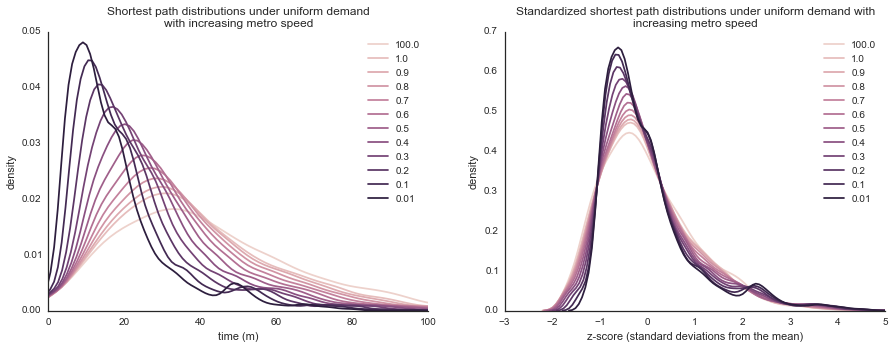

In [26]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for beta in betas: 
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'uniform_time_m', beta = beta)
    lengths = analysis.path_lengths_igraph(g, nodes, 'uniform_time_m', mode = 'array')
    sns.distplot(lengths, kde = True, hist = False, label = str(beta), ax = ax1)
    sns.distplot(analysis.standardize(lengths), kde = True, hist = False, label = str(beta), ax = ax2)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'uniform_time_m', beta = 1.0 / beta)

ax1.set(xlim = (0, 100), xlabel = 'time (m)', ylabel = 'density', title = 'Shortest path distributions under uniform demand \nwith increasing metro speed')
ax2.set(xlim = (-3, 5), xlabel = 'z-score (standard deviations from the mean)', ylabel = 'density', title = 'Standardized shortest path distributions under uniform demand with \nincreasing metro speed')
sns.despine()

Intriguing. We do find a certain amount of universality in the scaled distributions; however, as $\beta$ decreases, we do find that the distributions begin to change in both their quantitative characteristics (left) and their qualitative shape (right). We also observe a 'pocket' emerge for small $\beta$, which presumably reflects a small number of nodes that are very far from the metro and do not benefit from its speed increases. 

## 2.2 Shortest path distributions under OD demand

We are now in a position to compute shortest path distributions under OD demand. We'll construct a base table like last time. 

In [72]:
nodes = np.array([v.index for v in g.vs if v['layer'] == 'taz'])
if n_nodes:
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

indices = [(x,y) for (x,y) in itertools.product(range(len(nodes)), repeat=2)]
o_i = [x for (x,y) in indices]
d_i = [y for (x,y) in indices]

od_demand = pd.DataFrame({'o_i':o_i, 'd_i':d_i})

od_demand['o'] = od_demand['o_i'].map(lambda o_i : nodes[o_i]) # igraph keys
od_demand['d'] = od_demand['d_i'].map(lambda d_i : nodes[d_i]) # igraph keys

od_demand = od_demand.merge(od)

Now we'll compute shortest path lengths between each OD and added to the base table. 

In [73]:
for beta in betas:
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = beta)
    p = analysis.path_lengths_igraph(g, nodes, 'congested_time_m', mode = 'list')
    q = [(nodes[i],nodes[j],p[i][j]) for i in range(len(nodes)) for j in range(len(nodes))]
    o = [tup[0] for tup in q]
    d = [tup[1] for tup in q]
    p = [tup[2] for tup in q]
    lengths = pd.DataFrame({'o' : o, 'd' : d, 'congested_time_' + str(beta) : p})
    od_demand = od_demand.merge(lengths)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = 1.0 / beta)

Time to plot!

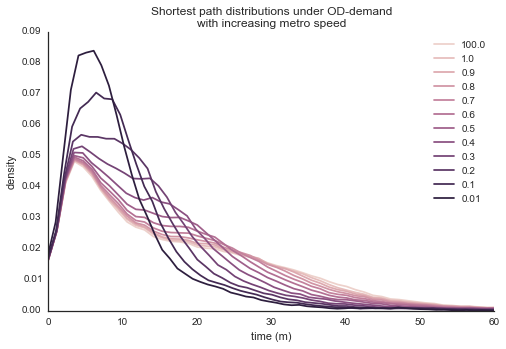

In [75]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)

for beta in betas:
    OD_weighted_hist(od_demand, 'congested_time_' + str(beta), label = str(beta))

ax.set(xlim = (0, 60), xlabel = 'time (m)', ylabel = 'density', title = 'Shortest path distributions under OD-demand \nwith increasing metro speed')
sns.despine()
plt.legend()

Now this is quite interesting! We observe that the distribution undergoes a kind of 'smoothing' as $\beta$ decreases, wherein the distribution begins to look much more like the standard $\Gamma$, lognormal, or Rayleigh distribution we observed in 1.1. We also don't observe substantial 'pockets' in the distributions, suggesting that, while some nodes are indeed very far from the proposed metro stops, there is no substantial travel demand from those nodes. 